Tutorial 4: Non-linear Search
=============================

The starting point for most scientific analysis conducted by an Astronomer is that they have observations of a galaxy
using a telescope like the Hubble Space Telescope, and seek to learn about the galaxy and the Universe from these
observations. With **PyAutoGalaxy**, we seek to learn about the galaxy's structure and morphology, asking questions like
how big is the galaxy, is it disky or bulgy, and how is its light distributed?

To answer these questions, we must therefore fit the dataset with a model of the galaxy, where the model defines the
light profile that make up the galaxy we fit. Our goal is the find the combination of light profile parameters that
best-fit the data, such that the model represents the galaxy, and therefore the Universe, as well as possible.

This process is called model-fitting, or "modeling" for short, and we actually did our first example of this in the
previous chapter. If you recall, in the fitting tutorial we set up a fit to a simulated dataset where the parameter
used to simulate the data were unknown, and you guessed the values of the parameters that best fit the data. You
iteratively improved the model-fit by guessing new parameters, over and over, finding solutions which produced
higher `log_likelihood` values.

However, this approach was not optimal: it was manual and slow, we had no certainty that we had found the best
(e.g. maximum likelihood) solution and for more complex models, with more parameters and light profiles, it would
have been completely unfeasible.

In this chapter, we perform modeling as a scientist would actually do it, and introduce the statistical inference
techniques that will ultimately allow us to fit complex models made of many light profiles to real galaxy data,
and begin learning about real galaxies in the Universe.

This first tutorial introduces a number of key statistical concepts that are fundamental to understanding how
model-fitting works, both for **PyAutoGalaxy** and in general.

__Overview__

In this tutorial, we will use a non-linear search to fit a single Serisc light profile to simulated imaging of a
galaxy. We will:

- Introduce concept like a "parameter space", "likelihood surface" and "priors", and relate them to how a non-linear
  search works.

- Introduce the `Analysis` class, which defines the `log_likelihood_function` that quantifies the goodness of fit of a
  model instance to the data.

- Fit datasets with different non-linear searches, including a maximum likelihood estimator (MLE),
  Markok Chain Monte Carlo (MCMC) and nested sampling.

__Contents__

This tutorial is split into the following sections:

- **Parameter Space**: Introduce the concept of a "parameter space" and how it relates to model-fitting.
- **Non-Linear Search**: Introduce the concept of a "non-linear search" and how it fits models to data.
- **Search Types**: Introduce the maximum likelihood estimator (MLE), Markov Chain Monte Carlo (MCMC) and nested sampling search algorithms used in this tutorial.
- **Deeper Background**: Provide links to resources that more thoroughly describe the statistical principles that underpin non-linear searches.
- **Data**: Load and plot the galaxy dataset we'll fit.
- **Model**: Introduce the galaxy model we'll fit to the data.
- **Priors**: Introduce priors and how they are used to define the parameter space and guide the non-linear search.
- **Analysis**: Introduce the `Analysis` class, which contains the `log_likelihood_function` used to fit the model to the data.
- **Searches**: An overview of the searches used in this tutorial.
- **Maximum Likelihood Estimation (MLE)**: Perform a model-fit using the MLE search.
- **Markov Chain Monte Carlo (MCMC)**: Perform a model-fit using the MCMC search.
- **Nested Sampling**: Perform a model-fit using the nested sampling search.
- **Result**: The result of the model-fit, including the maximum likelihood model.
- **Samples**: The samples of the non-linear search, used to compute parameter estimates and uncertainties.
- **Customizing Searches**: How to customize the settings of the non-linear search.
- **Wrap Up**: A summary of the concepts introduced in this tutorial.

__Parameter Space__

In mathematics, a function is defined by its parameters, which map inputs to outputs. For example, consider the simple function:

\[
f(x) = x^2
\]

Here, \(x\) is the input parameter, and \(f(x)\) returns the output \(x^2\). This relationship defines
the "parameter space" of the function, which in this case forms a parabola.

Functions can also have multiple parameters, such as:

\[
f(x, y, z) = x + y^2 - z^3
\]

This defines a parameter space in three dimensions, representing the relationships between \(x\), \(y\), \(z\),
and the output \(f(x, y, z)\).

This concept of parameter space is closely related to how we approach model-fitting. For instance, in chapter 1, w
e created instances of a `Galaxy` object with
parameters like \( (\text{`centre_0`}, \text{`centre_1`}, \text{`ell_comps_0`}, \text{`ell_comps_1`}, \text{`intensity`}, \text{`effective_radius`}, \text{`sersic_index`}) \).
These parameters were used to fit data and compute a log likelihood.

We can think of this process as analogous to the function \(f(\( (\text{`centre_0`}, \text{`centre_1`}, \text{`ell_comps_0`}, \text{`ell_comps_1`}, \text{`intensity`}, \text{`effective_radius`}, \text{`sersic_index`}) \))\),
where the output is the log likelihood. This function, which maps parameter values to a log likelihood, is known
as the "likelihood function" in statistical inference. To be explicit, we’ll refer to it as the `log_likelihood_function`
since it deals with the log of the likelihood function.

By framing the likelihood this way, we can think of our model as having its own parameter space—a multidimensional
surface defined by all possible values of the
parameters \( (\text{`centre_0`}, \text{`centre_1`}, \text{`ell_comps_0`}, \text{`ell_comps_1`}, \text{`intensity`}, \text{`effective_radius`}, \text{`sersic_index`}) \).
This surface, known as the "likelihood surface," represents how the log likelihood changes across different parameter
values. During model-fitting, our goal is to find the peak of this surface, where the fit to the data is optimal.

This parameter space is "non-linear," meaning the relationship between the model parameters and the log likelihood is
not a simple linear one. Because of this non-linearity, we cannot predict the log likelihood from a given set of model
parameters without actually performing a fit to the data, as we did in tutorial 1.

__Non-Linear Search__

Now that we understand our problem in terms of a non-linear parameter space with a likelihood surface, we can
introduce the method used to fit the model to the data —- the "non-linear search".

Previously, our approach involved manually guessing models until finding one with a good fit and high log likelihood.
Surprisingly, this random guessing forms the basis of how model-fitting using a non-linear search actually works!

A non-linear search involves systematically guessing many models while tracking their log likelihoods. As the
algorithm progresses, it tends to favor models with parameter combinations that have previously yielded higher
log likelihoods. This iterative refinement helps to efficiently explore the vast parameter space.

There are two key differences between guessing random models and using a non-linear search:

- **Computational Efficiency**: The non-linear search can evaluate the log likelihood of a model parameter
  combinations in milliseconds and therefore many thousands of models in minutes. This computational speed enables
  it to thoroughly sample potential solutions, which would be impractical for a human.

- **Effective Sampling**: The search algorithm maintains a robust memory of previously guessed models and their log
  likelihoods. This allows it to sample potential solutions more thoroughly and converge on the highest
  likelihood solutions more efficiently, which is again impractical for a human.

Think of the non-linear search as systematically exploring parameter space to pinpoint regions with the highest log
likelihood values. Its primary goal is to identify and converge on the parameter values that best describe the data.

__Search Types__

There are different types of non-linear searches, each of which explores parameter space in a unique way.
In this example, we will use three types of searches, which broadly represent the various approaches to non-linear
searches used in statistical inference.

These are:

- **Maximum Likelihood Estimation (MLE)**: This method aims to find the model that maximizes the likelihood function.
  It does so by testing nearby models and adjusting parameters in the direction that increases the likelihood.

- **Markov Chain Monte Carlo (MCMC)**: This approach uses a group of "walkers" that explore parameter space randomly.
  The likelihood at each walker's position influences the probability of the walker moving to a new position.

- **Nested Sampling**: This technique samples points from the parameter space iteratively. Lower likelihood points
  are replaced by higher likelihood ones, gradually concentrating the samples in regions of high likelihood.

We will provide more details on each of these searches below.

__Deeper Background__

**The descriptions of how searches work in this example are simplfied and phoenomenological and do not give a full
description of how they work at a deep statistical level. The goal is to provide you with an intuition for how to use
them and when different searches are appropriate for different problems. Later tutorials will provide a more formal
description of how these searches work.**

If you're interested in learning more about these principles, you can explore resources such as:

- [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
- [Introduction to MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)
- [Nested Sampling](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2016/NestedSampling_JRP.pdf)
- [A Zero-Math Introduction to MCMC Methods](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50)

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autogalaxy as ag
import autogalaxy.plot as aplt

C:\Users\Jammy\anaconda3\envs\PyAuto311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\Jammy\Code\PyAuto\BSc_Galaxies_Project
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\BSc_Galaxies_Project`


__PyAutoFit__

Modeling uses the probabilistic programming language
[PyAutoFit](https://github.com/rhayes777/PyAutoFit), an open-source project that allows complex model
fitting techniques to be straightforwardly integrated into scientific modeling software. 

**PyAutoFit** is actually a spin-off project of **PyAutoGalaxy**. whereby we found that the statistic techniques and
methods we applied to model galaxies could be used in a more general setting to many different scientific 
problems. Check it out if you are interested in developing your own software to perform advanced model-fitting!

We import this library separately from **PyAutoGalaxy**.

In [2]:
import autofit as af

__Initial Setup__

Let's first load the `Imaging` dataset, which we will use to fit a model with a non-linear search.

The galaxy in this image was generated using a `Sersic` light profile, which we'll also use in our model fitting 
in this tutorial. This means the model we are going to fit is identical to the one used to simulate the data, 
allowing us to assess the fitting process under controlled conditions.

The dataset, as well as all subsequent datasets used in future tutorials, is stored in 
the `autogalaxy_workspace/dataset/imaging` folder. 

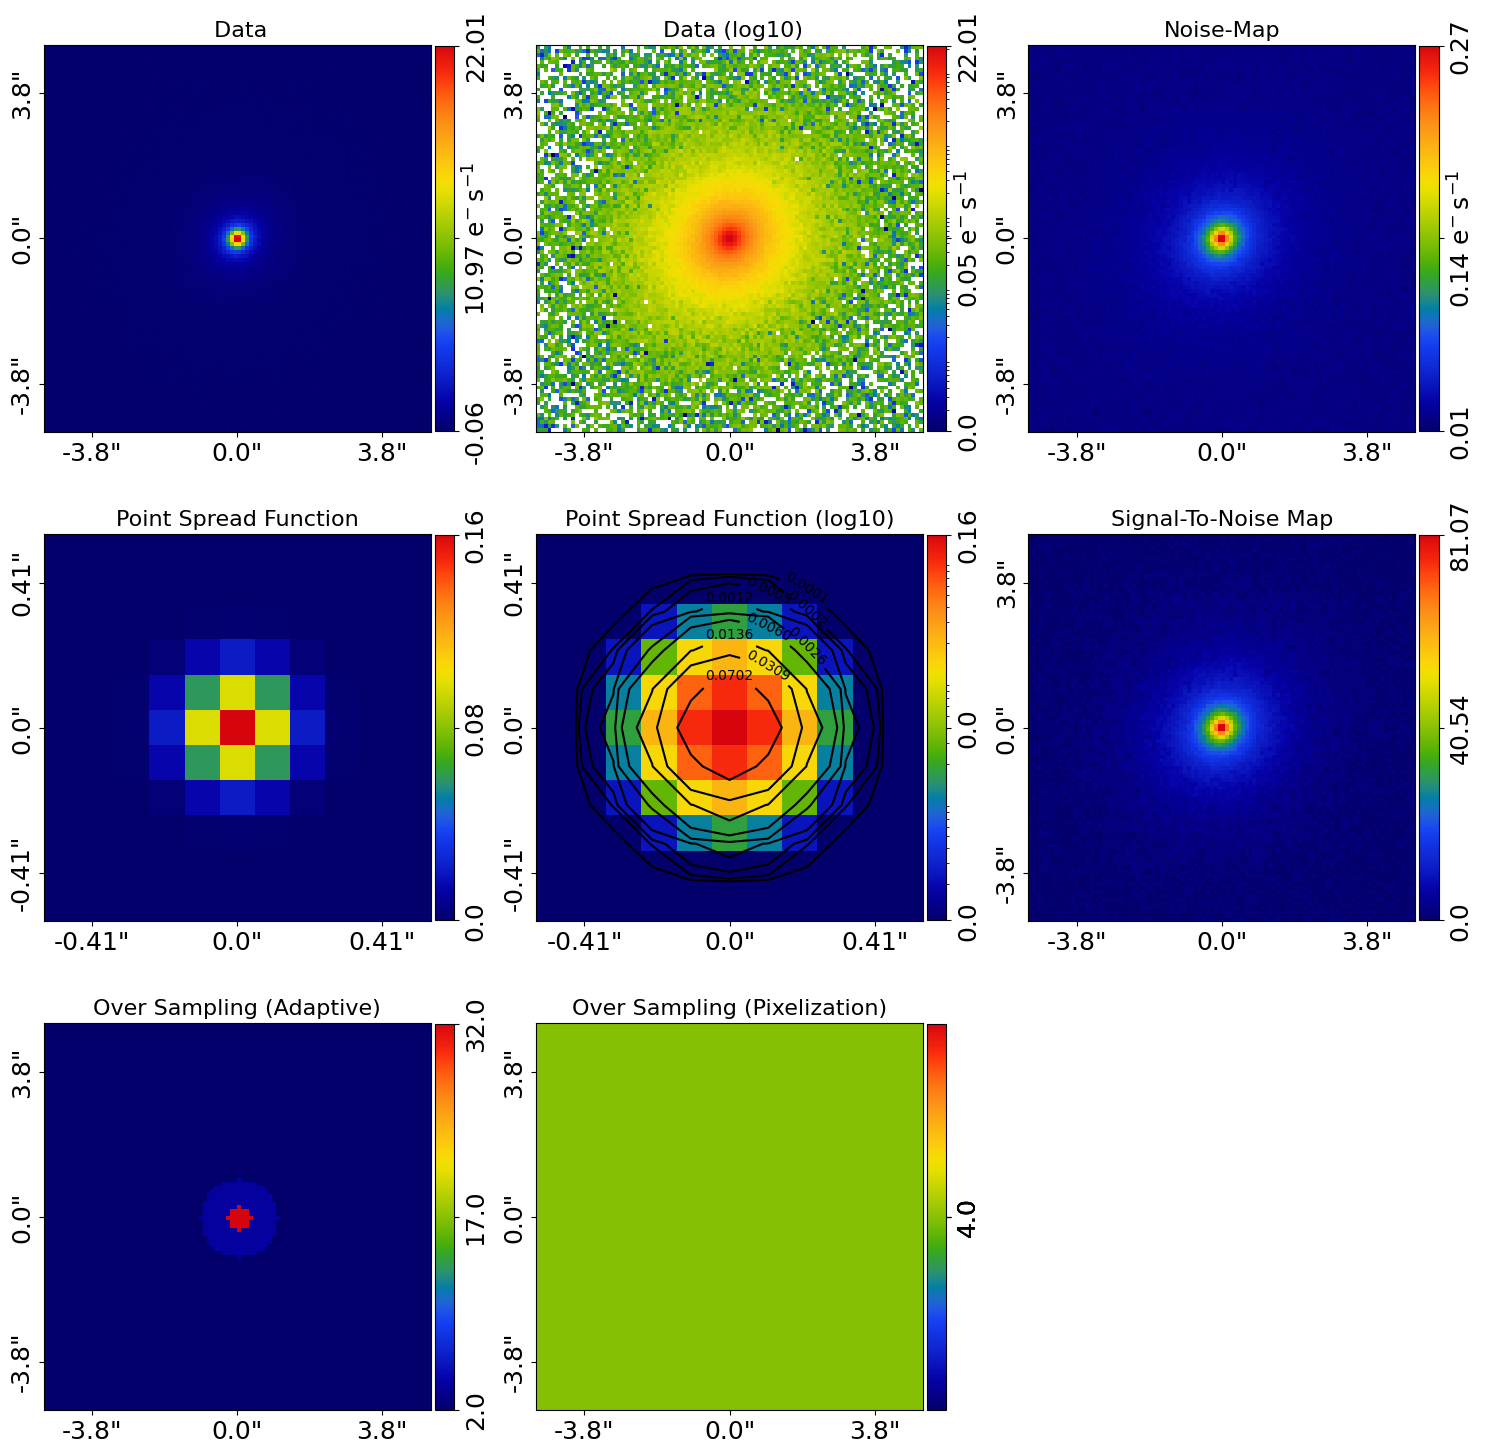

In [3]:
dataset_name = "simple__sersic"
dataset_path = path.join("dataset", "imaging", dataset_name)

dataset = ag.Imaging.from_fits(
    data_path=path.join(dataset_path, "data.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.subplot_dataset()

__Mask__

The fit requires a mask, which we define as a 3.0" circle.

2024-10-30 12:10:05,686 - autoarray.dataset.imaging.dataset - INFO - IMAGING - Data masked, contains a total of 2828 image-pixels


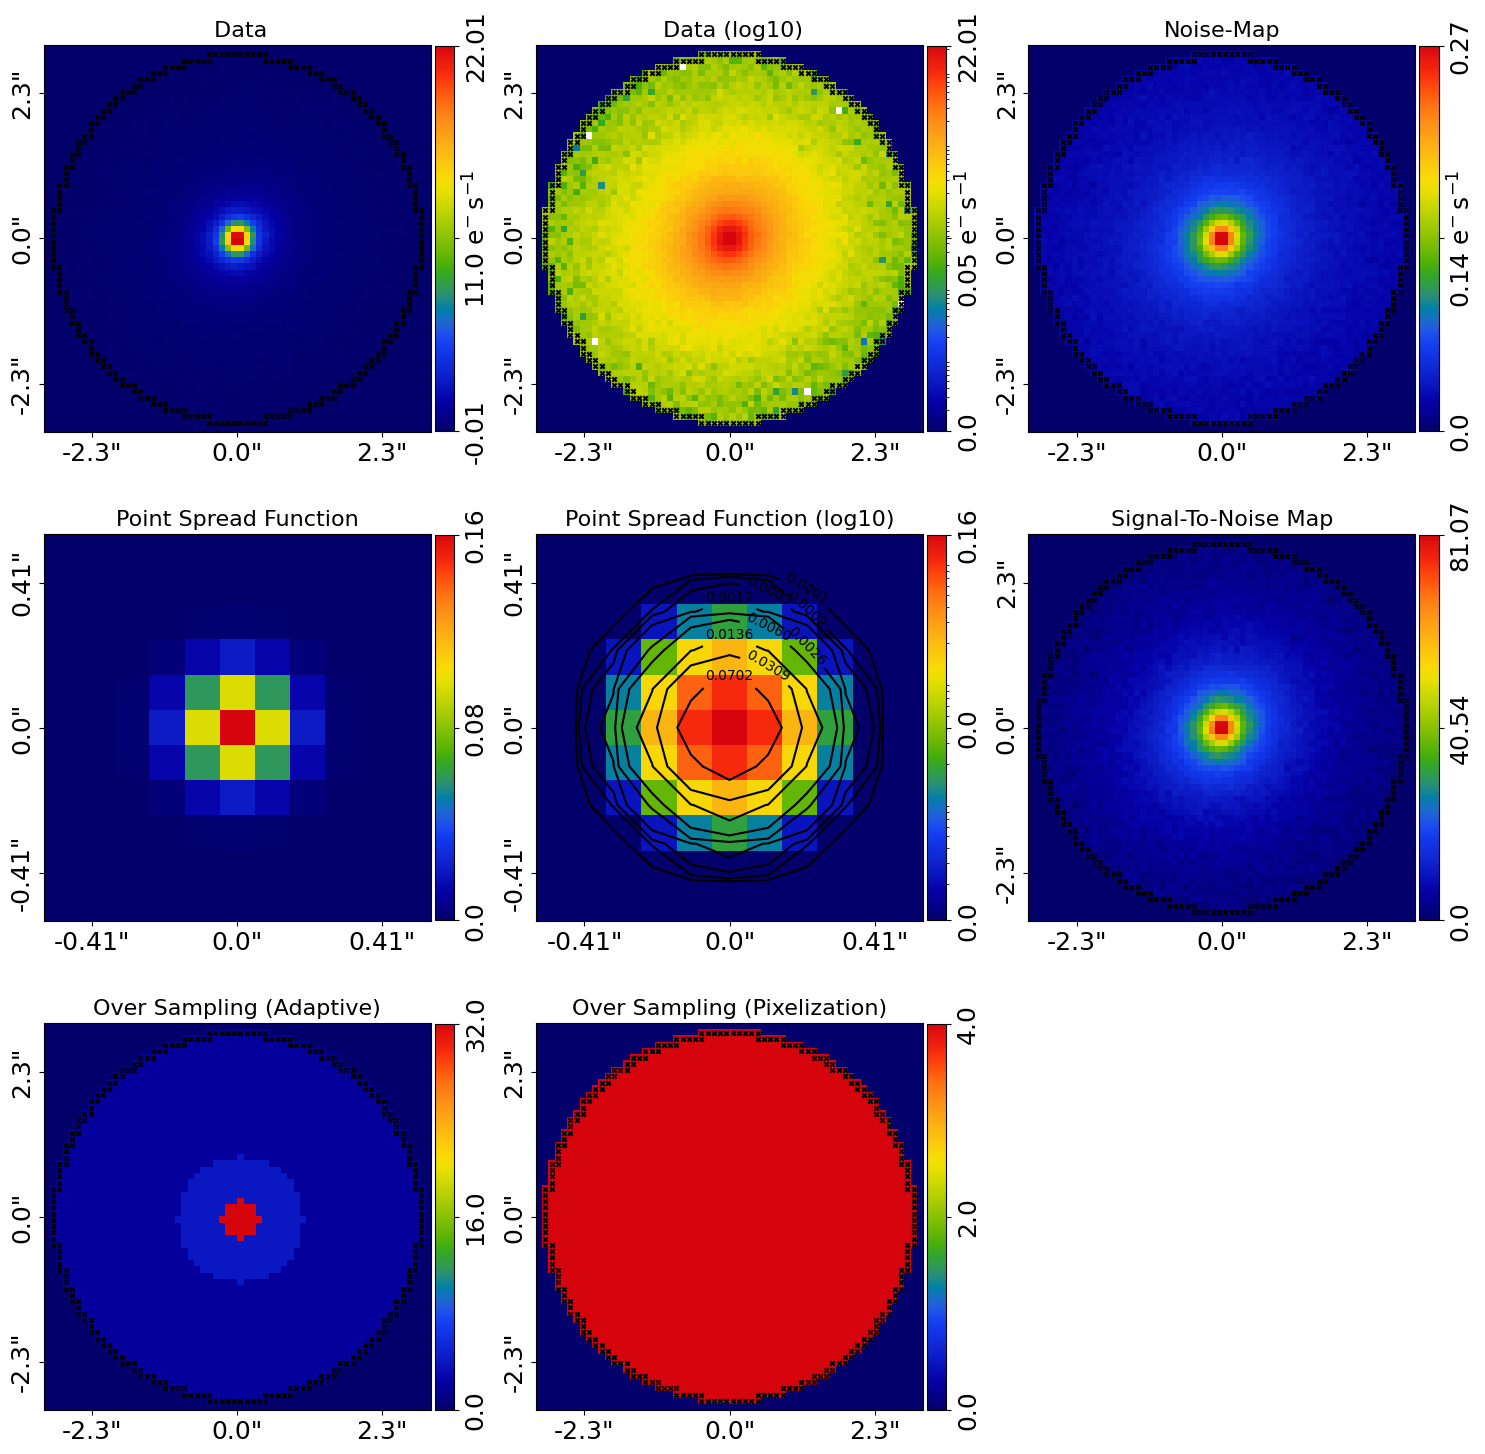

In [4]:
mask = ag.Mask2D.circular(
    shape_native=dataset.shape_native, pixel_scales=dataset.pixel_scales, radius=3.0
)

dataset = dataset.apply_mask(mask=mask)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.subplot_dataset()

__Model__

To compose a model, we will set up a `Galaxy` using a `af.Model`. Instead of manually specifying every parameter 
for the galaxy's light profiles (as we did before), we will now define the galaxy using only the class of each 
profile. Using a `Model` object tells **PyAutoGalaxy** that the parameters of the profiles should be fitted for 
during the non-linear search.

In this case, we'll model the galaxy with an elliptical Sersic light profile, which is linear and represents 
its bulge component (the same profile used to simulate the galaxy). 

In [5]:
galaxy_model = af.Model(ag.Galaxy, redshift=0.5, bulge=ag.lp_linear.Sersic)

We now input the model component into a `Collection` object, which groups all the model components used to fit the data.

As with profiles, we give galaxies descriptive names like `bulge`, or `disk`. Since this model has only one 
galaxy, we'll simply refer to it as `galaxy` throughout the tutorials.

It may seem odd that we define two `Collections`, with the `Collection` in the outer loop only having a `galaxies`
attribute. In future tutorials, we'll see that we can add additional model-components to a model other than just
galaxies, and the API below therefore makes it simple to extend the model to include these components.

In [6]:
model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

The `info` attribute shows the model in a readable format.

[The `info` below may not display optimally on your computer screen, for example the whitespace between parameter
names on the left and parameter priors on the right may lead them to appear across multiple lines. This is a
common issue in Jupyter notebooks.

The`info_whitespace_length` parameter in the file `config/generag.yaml` in the [output] section can be changed to 
increase or decrease the amount of whitespace (The Jupyter notebook kernel will need to be reset for this change to 
appear in a notebook).]

In [7]:
print(model.info)

Total Free Parameters = 6

model                                                                           Collection (N=6)
    galaxies                                                                    Collection (N=6)
        galaxy                                                                  Galaxy (N=6)
            bulge                                                               Sersic (N=6)

galaxies
    galaxy
        redshift                                                                0.5
        bulge
            centre
                centre_0                                                        GaussianPrior [0], mean = 0.0, sigma = 0.3
                centre_1                                                        GaussianPrior [1], mean = 0.0, sigma = 0.3
            ell_comps
                ell_comps_0                                                     GaussianPrior [2], mean = 0.0, sigma = 0.3
                ell_comps_1                                     

__Priors__

When we examine the `.info` of our model, we notice that each parameter (like `centre`, `effective_radius`, 
and `sersic_index` in our `Sersic` model) is associated with priors, such as `UniformPrior`. Priors define the 
range of permissible values that each parameter can assume during the model fitting process, for example a uniform
prior means that a parameter is equally likely to be any value within the given range, but cannot be outside of it.

The priors displayed above use default values defined in the `config/priors` directory. These default values have
been chosen to be broad, and contain the breadth of plausible solutions one should expect when fitting light
profiles to a real galaxy.

For instance, consider the `centre` parameter of our `Sersic` light profile. In theory, it could take on any value from 
negative to positive infinity. However, imaging datasets are typically reduced such that the galaxy centre is close 
to (0.0", 0.0"). Therefore, a `GaussianPrior` with `mean=0.0` and `sigma=0.1` is a good description of where the
galaxy `centre` is. 

If the galaxy had a different centre in the dataset, we would change the mean of the prior to reflect this.
However, in general, we advise all galaxy images are reduced such that the galaxy is at (0.0", 0.0").

Priors serve two primary purposes:

**Defining Valid Parameter Space:** Priors specify the range of parameter values that constitute valid solutions. 
This ensures that our model explores only those solutions that are consistent with our observed data and physical 
constraints.

**Incorporating Prior Knowledge:** Priors also encapsulate our prior beliefs or expectations about the model 
parameters. For instance, if we have previously fitted a similar model to another dataset and obtained certain 
parameter values, we can incorporate this knowledge into our priors for a new dataset. This approach guides the 
model fitting process towards parameter values that are more probable based on our prior understanding.

Below, we manually specify the priors on all parameter in our `Sersic` model. The custom priors below are
close to the default priors drawn via configfiles, with the main purpose of the code below to show you how to
customize priors yourself.

In [8]:
model.galaxies.galaxy.bulge.centre.centre_0 = af.GaussianPrior(mean=0.0, sigma=0.1)
model.galaxies.galaxy.bulge.centre.centre_1 = af.GaussianPrior(mean=0.0, sigma=0.1)
model.galaxies.galaxy.bulge.ell_comps.ell_comps_0 = af.UniformPrior(
    lower_limit=-1.0, upper_limit=1.0
)
model.galaxies.galaxy.bulge.ell_comps.ell_comps_1 = af.UniformPrior(
    lower_limit=-1.0, upper_limit=1.0
)
model.galaxies.galaxy.bulge.effective_radius = af.UniformPrior(
    lower_limit=0.0, upper_limit=10.0
)
model.galaxies.galaxy.bulge.sersic_index = af.UniformPrior(
    lower_limit=0.8, upper_limit=8.0
)

By reprinting the `model.info`, we can see that the priors have been updated to the values we specified.

In [ ]:
print(model.info)

__Analysis__

The `AnalysisImaging` object defines how an instance of a model, consisting of a set of parameters values for the 
light profiles, is fitted to the `Imaging` dataset.

The fit is performed using the analysis class's `log_likelihood_function`, which in model-fitting is a commonly used 
term to describe a function that given a model and data, fits the model to the data to return a value of log 
likelihood. 

In the fitting tutorial in chapter 1 you essentially performed this likelihood function yourself by hand, when you 
entered different models to a `FitImaging` object and used its `log_likelihood` property to quantify how well it 
fitted the data.

A detailed step-by-step visual guide of the likelihood function is provided 
at `autogalaxy_workspace/*/imaging/log_likelihood_function/parametric.ipynb`.

In [9]:
analysis = ag.AnalysisImaging(dataset=dataset)

__Searches__

To perform a non-linear search, we create an instance of a `NonLinearSearch` object. **PyAutoFit** offers many options 
for this. A detailed description of each search method and guidance on when to use them can be found in 
the [search cookbook](https://pyautofit.readthedocs.io/en/latest/cookbooks/search.html).

In this tutorial, we’ll focus on three searches that represent different approaches to model fitting:

1. **Maximum Likelihood Estimation (MLE)** using the `LBFGS` non-linear search.
2. **Markov Chain Monte Carlo (MCMC)** using the `Emcee` non-linear search.
3. **Nested Sampling** using the `Nautilus` non-linear search.

In this example, non-linear search results are stored in memory rather and not written to hard disk because the fits 
are fast and can therefore be easily regenerated. The next tutorial will perform fits which write results to the
hard-disk and discuss the outputs that are generated.

__Maximum Likelihood Estimation (MLE)__

Maximum likelihood estimation (MLE) is the most straightforward type of non-linear search. Here is a simplified 
overview of how it works:

1. Starts at a point in parameter space with a set of initial values for the model parameters.
2. Calculates the likelihood of the model at this starting point.
3. Evaluates the likelihood at nearby points to estimate the gradient, determining the direction in which to move "up" in parameter space.
4. Moves to a new point where, based on the gradient, the likelihood is higher.

This process repeats until the search finds a point where the likelihood can no longer be improved, indicating that 
the maximum likelihood has been reached.

The `LBFGS` search is an example of an MLE algorithm that follows this iterative procedure. Let’s see how it 
performs on our Sersic model.

In the example below, we do not specify a starting point for the MLE, so it begins at the center of the prior 
range for each parameter.

In [10]:
search = af.LBFGS()

To begin the model-fit via the non-linear search, we pass it our model and analysis and begin the fit.

The fit will take a minute or so to run.

In [11]:
print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-10-30 12:10:07,950 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-10-30 12:10:07,952 - autogalaxy.analysis.analysis.dataset - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2024-10-30 12:10:09,359 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-10-30 12:10:09,364 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-10-30 12:10:09,365 - process 0 - INFO - created
2024-10-30 12:10:15,933 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-10-30 12:10:16,215 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search
2024-10-30 12:10:16,721 - root - INFO - Starting new L-BFGS-B non-linear sea

Upon completion the non-linear search returns a `Result` object, which contains information about the model-fit.

The `info` attribute shows the result in a readable format.

[Above, we discussed that the `info_whitespace_length` parameter in the config files could b changed to make 
the `model.info` attribute display optimally on your computer. This attribute also controls the whitespace of the
`result.info` attribute.]

In [12]:
print(result.info)


Maximum Log Likelihood                                                          -20318.10206659
Maximum Log Posterior                                                           -20317.48129365

model                                                                           Collection (N=6)
    galaxies                                                                    Collection (N=6)
        galaxy                                                                  Galaxy (N=6)
            bulge                                                               Sersic (N=6)

Maximum Log Likelihood Model:

galaxies
    galaxy
        bulge
            centre
                centre_0                                                        0.103
                centre_1                                                        -0.042
            ell_comps
                ell_comps_0                                                     0.180
                ell_comps_1                                  

One thing the result contains we'll use now is the `FitImaging` object that corresponds to the set of model
parameters that gave the maximum log likelihood solution. 

We plot this object to inspect how good our fit was.

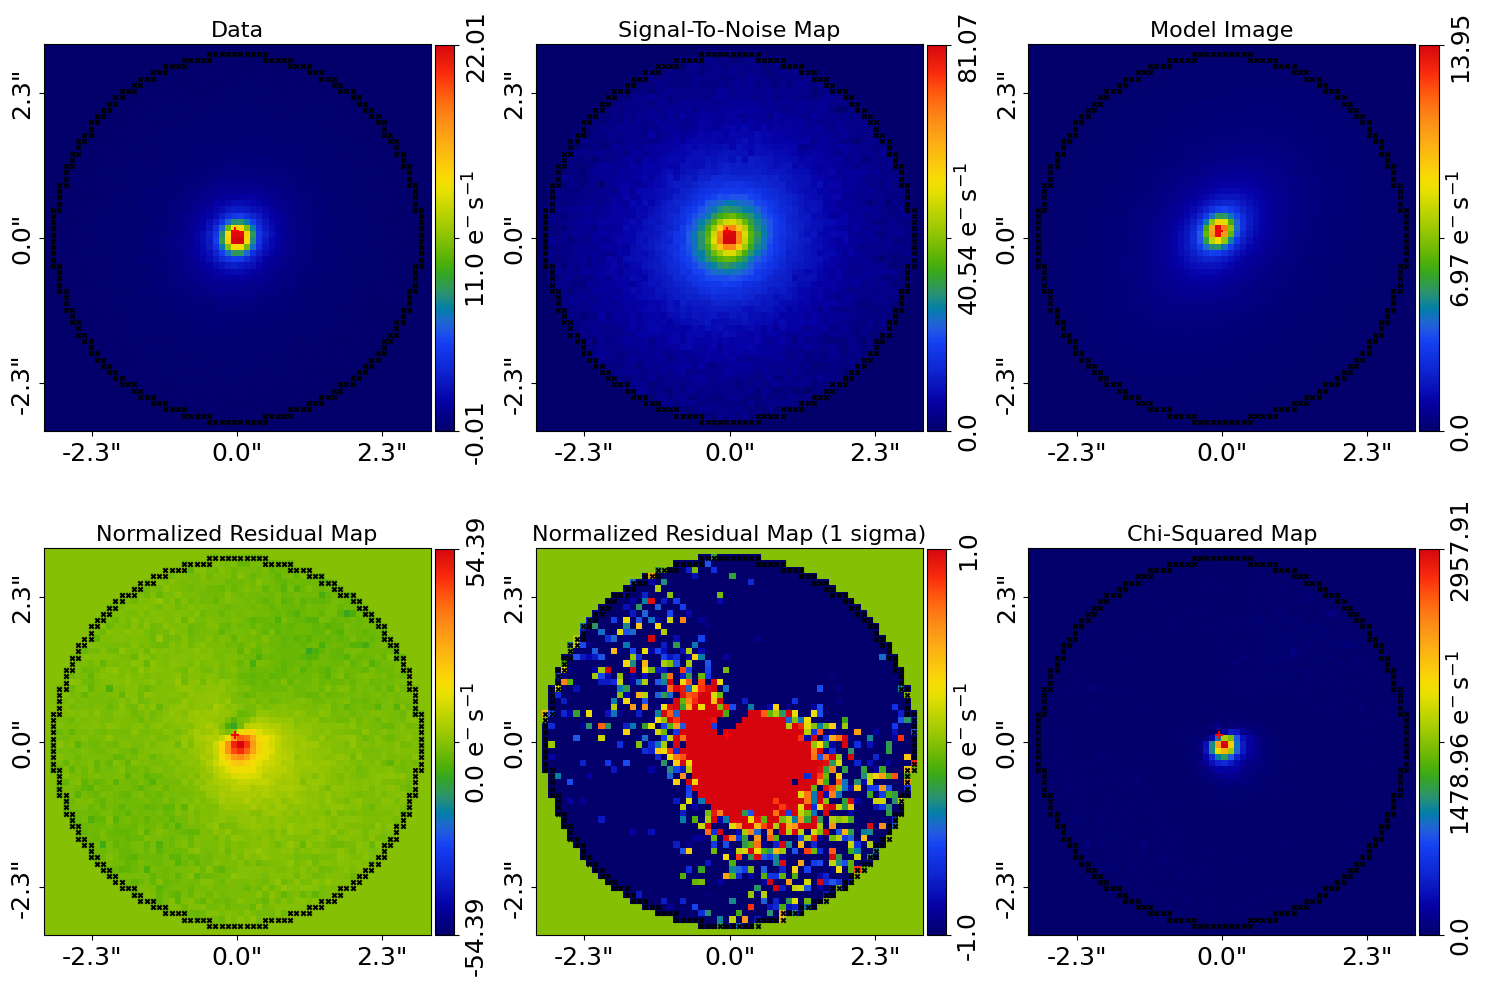

In [13]:
fit_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_plotter.subplot_fit()

The fit quality is poor, with significant residuals, meaning that the MLE failed to identify the correct model. 

This happened because the starting point of the search was a poor match to the data, placing it far from the true 
solution in parameter space. As a result, after moving "up" the likelihood gradient several times, the search 
settled into a "local maximum", a local peak in the likelihood surface that was better than models that surrounded
it in parameter space, but far from the global maximum solution.

To achieve a better fit with MLE, the search needs to begin in a region of parameter space where the log likelihood 
is higher. This process is known as "initialization" and it involves providing the search with an 
appropriate "starting point" in parameter space.

The code below shows how we can customize the starting point of the search to provide a better initialization,
with the values input below close to the true values used to simulate the dataset.

In [14]:
initializer = af.InitializerParamStartPoints(
    {
        model.galaxies.galaxy.bulge.centre.centre_0: 0.0,
        model.galaxies.galaxy.bulge.centre.centre_1: 0.0,
        model.galaxies.galaxy.bulge.ell_comps.ell_comps_0: 0.1,
        model.galaxies.galaxy.bulge.ell_comps.ell_comps_1: 0.05,
        model.galaxies.galaxy.bulge.effective_radius: 1.0,
        model.galaxies.galaxy.bulge.sersic_index: 3.7,
    }
)

search = af.LBFGS(initializer=initializer)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-10-30 12:10:18,853 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-10-30 12:10:18,854 - autogalaxy.analysis.analysis.dataset - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2024-10-30 12:10:18,906 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-10-30 12:10:18,911 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-10-30 12:10:18,912 - process 0 - INFO - created
2024-10-30 12:10:25,852 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-10-30 12:10:26,167 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search
2024-10-30 12:10:26,676 - root - INFO - Starting new L-BFGS-B non-linear sea

By printing `result.info` and looking at the maximum log likelihood model, we can confirm the search provided a
good model fit with a much higher likelihood than the incorrect model above.

Maximum Log Likelihood                                                          5715.42309706
Maximum Log Posterior                                                           5715.42309928

model                                                                           Collection (N=6)
    galaxies                                                                    Collection (N=6)
        galaxy                                                                  Galaxy (N=6)
            bulge                                                               Sersic (N=6)

Maximum Log Likelihood Model:

galaxies
    galaxy
        bulge
            centre
                centre_0                                                        -0.000
                centre_1                                                        -0.000
            ell_comps
                ell_comps_0                                                     0.054
                ell_comps_1                                     

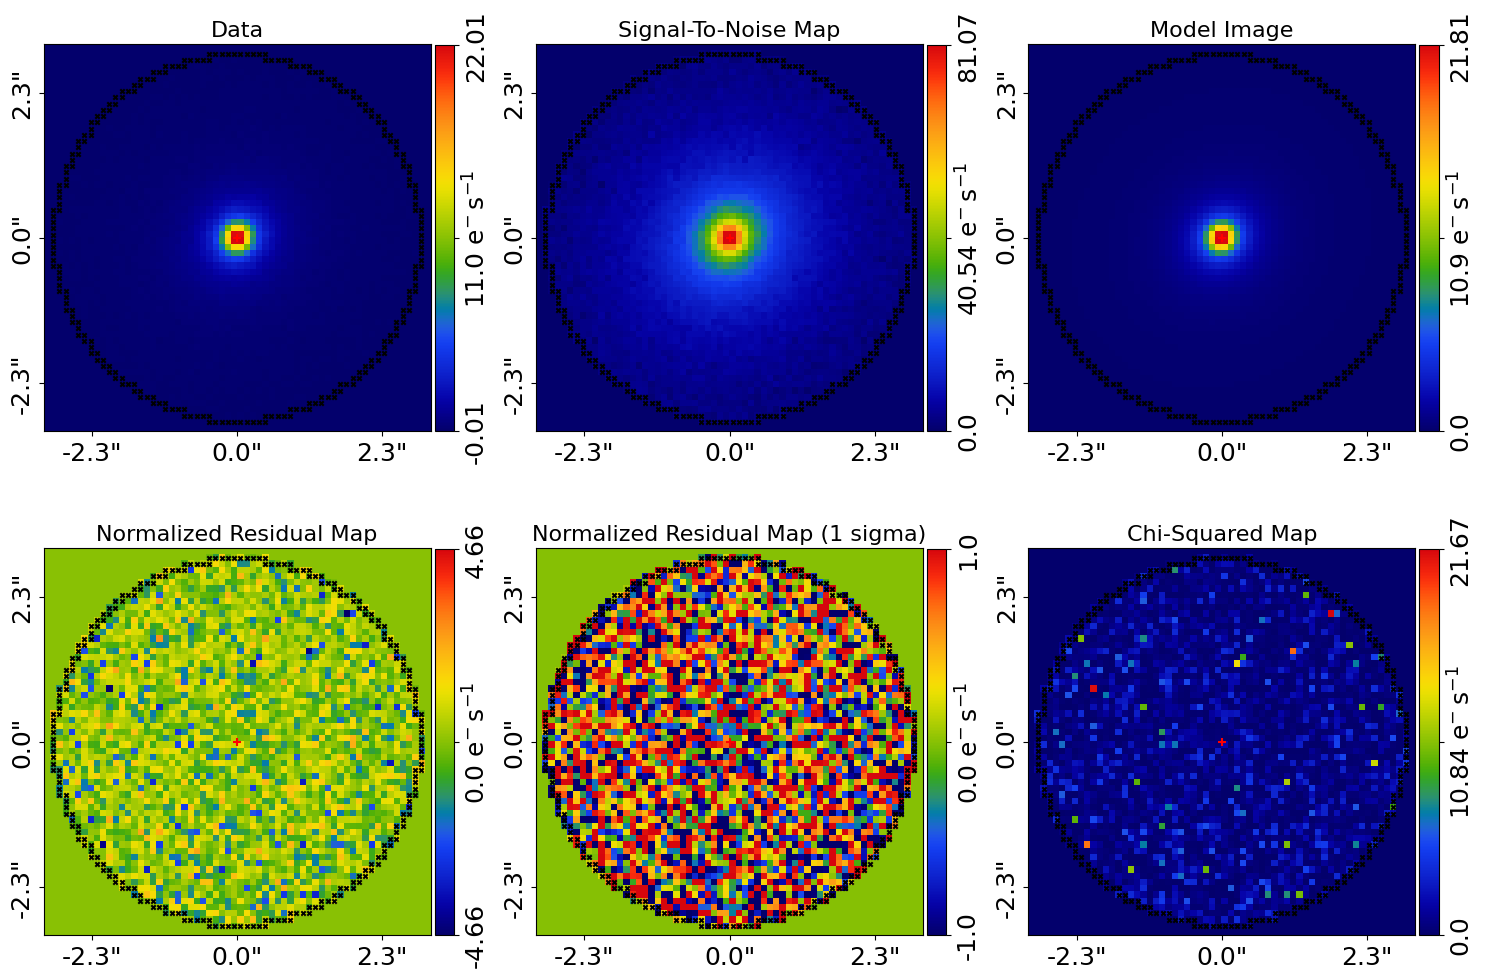

In [15]:
print(result.info)

fit_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_plotter.subplot_fit()

The MLE is a great starting point for model-fitting because it’s fast, conceptually simple, and often yields 
accurate results. It is especially effective if you can provide a good initialization, allowing it to find the 
best-fit solution quickly.

However, MLE has its limitations. As seen above, it can get "stuck" in a local maximum, particularly if the 
starting point is poorly chosen. In complex model-fitting problems, providing a suitable starting point can be 
challenging. While MLE performed well in the example with just three parameters, it struggles with models that have 
many parameters, as the complexity of the likelihood surface makes simply moving "up" the gradient less effective.

The MLE also does not provide any information on the errors on the parameters, which is a significant limitation.
The next two types of searches "map out" the likelihood surface, such that they not only infer the maximum likelihood
solution but also quantify the errors on the parameters.

__Markov Chain Monte Carlo (MCMC)__

Markov Chain Monte Carlo (MCMC) is a more powerful method for model-fitting, though it is also more computationally 
intensive and conceptually complex. Here’s a simplified overview:

1. Place a set of "walkers" in parameter space, each with random parameter values.
2. Calculate the likelihood of each walker's position.
3. Move the walkers to new positions, guided by the likelihood of their current positions. Walkers in high-likelihood 
regions encourage those in lower regions to move closer to them.

This process repeats, with the walkers converging on the highest-likelihood regions of parameter space.

Unlike MLE, MCMC thoroughly explores parameter space. While MLE moves a single point up the likelihood gradient, 
MCMC uses many walkers to explore high-likelihood regions, making it more effective at finding the global maximum, 
though slower. 

There is a reduced risk of getting stuck in local maxima, because whilst some walkers may temporarily get stuck in 
one, other walkers will explore other regions of parameter space and encourage the walker in local maxima to move 
away from it and head towards higher likelihood regions.

In the example below, we use the `Emcee` MCMC search to fit the galaxy. The search starts with walkers 
initialized in a "ball" around the center of the model’s priors, similar to the MLE search that failed earlier.


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-10-30 12:10:33,625 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-10-30 12:10:33,626 - autogalaxy.analysis.analysis.dataset - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2024-10-30 12:10:33,670 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-10-30 12:10:33,676 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-10-30 12:10:33,677 - process 0 - INFO - created
2024-10-30 12:10:40,325 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-10-30 12:10:41,081 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search
2024-10-30 12:10:41,584 - root - INFO - Starting new Emcee non-linear search

100%|██████████| 300/300 [01:26<00:00,  3.46it/s]

2024-10-30 12:12:08,811 - root - INFO - Search complete, returning result


The search has finished run - you may now continue the notebook.
Maximum Log Likelihood                                                          3193.19122747
Maximum Log Posterior                                                           3193.26236051

model                                                                           Collection (N=6)
    galaxies                                                                    Collection (N=6)
        galaxy                                                                  Galaxy (N=6)
            bulge                                                               Sersic (N=6)

Maximum Log Likelihood Model:

galaxies
    galaxy
        bulge
            centre
                centre_0                                                        0.036
                centre_1                                                        -0.010
            ell_comps
                ell_comps_0                                                     0.017


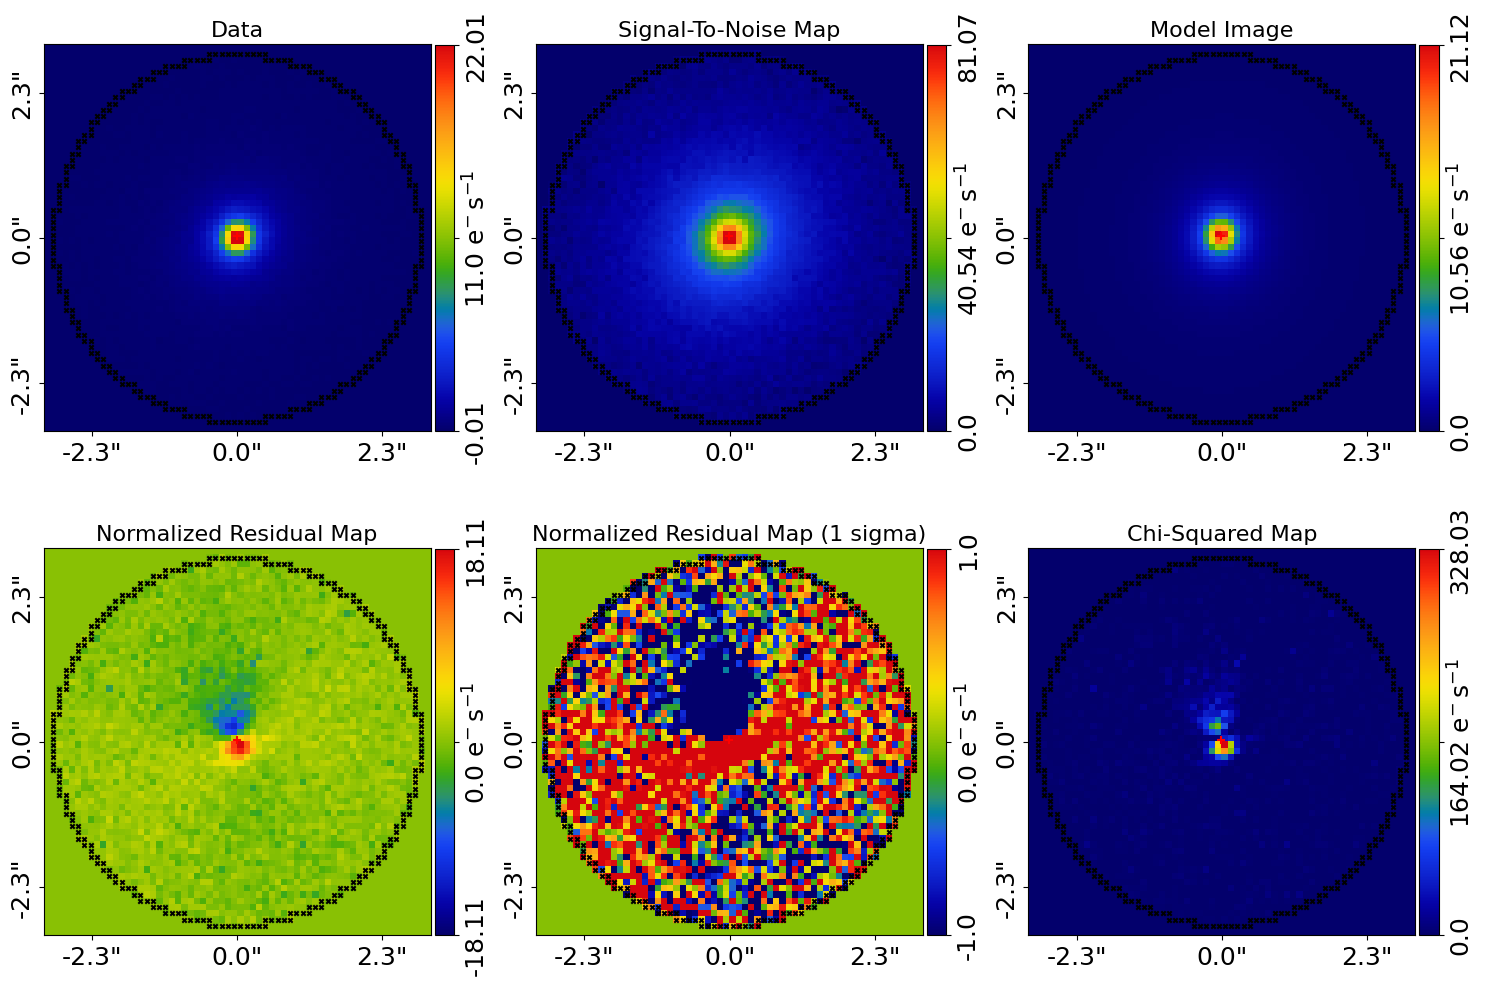

In [16]:
search = af.Emcee(
    nwalkers=20,  # The number of walkers we'll use to sample parameter space.
    nsteps=300,  # The number of steps each walker takes, after which 20 * 300 = 6000 steps the non-linear search ends.
)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")

print(result.info)

fit_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_plotter.subplot_fit()

The MCMC search succeeded, finding the same high-likelihood model that the MLE search with a good starting point 
identified, even without a good initialization. Its use of multiple walkers exploring parameter space allowed it to 
avoid the local maxima that had trapped the MLE search.

A major advantage of MCMC is that it provides estimates of parameter uncertainties by "mapping out" the likelihood 
surface, unlike MLE, which only finds the maximum likelihood solution. These error estimates are accessible in 
the `result.info` string and through the `result.samples` object, which is explained fully in tutorial 5.

While a good starting point wasn't necessary for this simple model, it becomes essential for efficiently mapping the 
likelihood surface in more complex models with many parameters. The code below shows an MCMC fit using a good starting 
point, with two key differences from the MLE initialization:

1. Instead of single starting values, we provide bounds for each parameter. MCMC initializes each walker in a 
small "ball" in parameter space, requiring a defined range for each parameter from which values are randomly drawn.

2. We do not specify a starting point for the `ell_comps` parameters, allowing its initial values to be drawn from its 
priors. This illustrates that with MCMC, it’s not necessary to know a good starting point for every parameter.

In [17]:
initializer = af.InitializerParamBounds(
    {
        model.galaxies.galaxy.bulge.centre.centre_0: (-0.01, 0.01),
        model.galaxies.galaxy.bulge.centre.centre_1: (-0.01, 0.01),
        model.galaxies.galaxy.bulge.effective_radius: (0.0, 2.0),
        model.galaxies.galaxy.bulge.sersic_index: (3.0, 5.0),
    }
)

search = af.Emcee(
    nwalkers=20,  # The number of walkers we'll use to sample parameter space.
    nsteps=300,  # The number of steps each walker takes, after which 10 * 200 = 2000 steps the non-linear search ends.
    initializer=initializer,
)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")

print(result.info)


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-10-30 12:12:10,367 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-10-30 12:12:10,368 - autogalaxy.analysis.analysis.dataset - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2024-10-30 12:12:10,412 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-10-30 12:12:10,417 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-10-30 12:12:10,418 - process 0 - INFO - created
2024-10-30 12:12:17,955 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-10-30 12:12:17,957 - autofit.non_linear.initializer - WARNING - Range for galaxies.galaxy.bulge.ell_comps.ell_comps_0 not set in the InitializerParamBounds. Using defaults.
2024-10-30 12:12:1

100%|██████████| 300/300 [01:47<00:00,  2.79it/s]


2024-10-30 12:14:07,274 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.
Maximum Log Likelihood                                                          5714.84196058
Maximum Log Posterior                                                           5714.84217937

model                                                                           Collection (N=6)
    galaxies                                                                    Collection (N=6)
        galaxy                                                                  Galaxy (N=6)
            bulge                                                               Sersic (N=6)

Maximum Log Likelihood Model:

galaxies
    galaxy
        bulge
            centre
                centre_0                                                        -0.002
                centre_1                                                        -0.001
            ell_comps
           

MCMC is a powerful tool for model-fitting, providing accurate parameter estimates and uncertainties. For simple models
without a starting point, MCMC can still find the correct solution, and if a good starting point is provided, it can
efficiently scale to more complex models with more parameters.

The main limitation of MCMC is that one has to supply the number of steps the walkers take (`nsteps`). If this value 
is too low, the walkers may not explore the likelihood surface sufficiently. It can be challenging to know the right 
number of steps, especially if models of different complexity are being fitted or if datasets of varying quality are 
used. One often ends up having to perform "trial and error" to verify a sufficient number of steps are used.

MCMC can perform badly in parameter spaces with certain types of complexity, for example when there are
are many local maxima "peaks" that many of the walkers can become stuck walking around them, so many walkers that
when they communicate with one another they cannot gain enough information to move away from the local peak.

__Nested Sampling__

**Nested Sampling** is an advanced method for model-fitting that excels in handling complex models with intricate 
parameter spaces. Here’s a simplified overview of its process:

1. Start with a set of "live points" in parameter space, each initialized with random parameter values drawn from their respective priors.

2. Compute the log likelihood for each live point.

3. Draw a new point based on the likelihood of the current live points, favoring regions of higher likelihood.

4. If the new point has a higher likelihood than any existing live point, it becomes a live point, and the lowest likelihood live point is discarded.

This iterative process continues, gradually focusing the live points around higher likelihood regions of parameter 
space until they converge on the highest likelihood solution.

Like MCMC, Nested Sampling effectively maps out parameter space, providing accurate estimates of parameters and 
their uncertainties.

In [18]:
search = af.Nautilus(
    n_live=100,
)

To begin the model-fit via the non-linear search, we pass it our model and analysis and begin the fit.

The fit will take a minute or so to run.


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-10-30 12:14:07,323 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-10-30 12:14:07,324 - autogalaxy.analysis.analysis.dataset - INFO - PRELOADS - Setting up preloads, may take a few minutes for fits using an inversion.
2024-10-30 12:14:07,368 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-10-30 12:14:07,373 - root - INFO - Starting new Nautilus non-linear search (no previous samples found).
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 37     | 1        | 4        | 7300     | N/A    | 1038  | +5680.78 
2024-10-30 12:17:18,329 - root - INFO - Search complete, returning result
The search has finished run - y

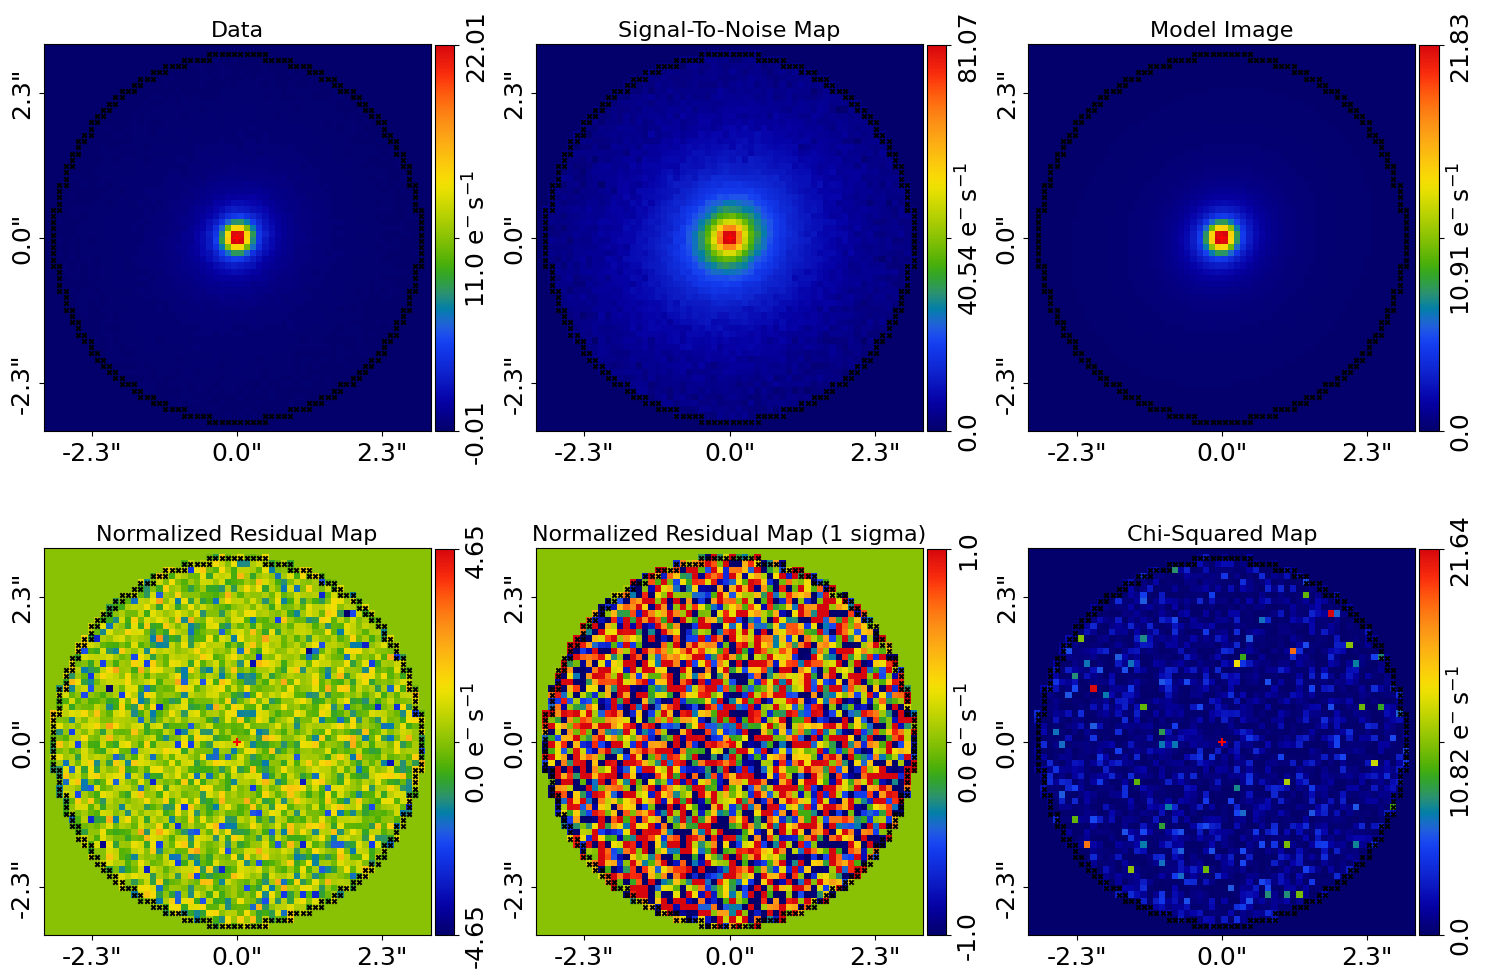

In [19]:
print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")

print(result.info)

fit_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_plotter.subplot_fit()

The **Nested Sampling** search was successful, identifying the same high-likelihood model as the MLE and MCMC searches. 
One of the main benefits of Nested Sampling is its ability to provide accurate parameter estimates and uncertainties, 
similar to MCMC. Additionally, it features a built-in stopping criterion, which eliminates the need for users to 
specify the number of steps the search should take. 

This method also excels in handling complex parameter spaces, particularly those with multiple local peaks. This is because
the live points will identify each peak and converge around them, but then begin to be discarded from a peak if higher
likelihood points are found elsewhere in parameter space. In MCMC, the walkers can get stuck indefinitely in
peaks, causing the method to stall.

Another significant advantage is that Nested Sampling estimates an important statistical quantity 
known as "evidence." This value quantifies how well the model fits the data while considering the model's complexity,
making it essential for Bayesian model comparison, which will be covered in later tutorials. 

Nested sampling cannot use a starting point, as it always samples parameter space from scratch by drawing live points
from the priors. This is both good and bad, depending on if you have access to a good starting point or not. If you do
not, your MCMC / MLE fit will likely struggle with initialization compared to Nested Sampling. Conversely, if you do 
possess a robust starting point, it can significantly enhance the performance of MCMC, allowing it to begin closer to 
the highest likelihood regions of parameter space. This proximity can lead to faster convergence and more reliable results.

However, Nested Sampling does have limitations; it often scales poorly with increased model complexity. For example, 
once a model has around 50 or more parameters, Nested Sampling can become very slow, whereas MCMC remains efficient 
even in such complex parameter spaces.

__What is The Best Search To Use?__

In statistical inference, the choice of the best search method depends on several factors specific to the problem, 
such as model complexity, availability of a starting point, and whether error estimates are required. More subtle 
aspects, like the shape of the likelihood surface and the presence of multiple peaks, also play a role, as you'll 
explore in later tutorials.

When approaching a model-fitting problem, it's usually advisable to try various search methods to find the most 
effective one. 

However, after extensive testing within **PyAutoGalaxy**, a clear recommendation has emerged for fitting galaxy light 
profiles and studying galaxy structure. The nested sampling method `Nautilus` consistently proves to be the most 
effective. It requires fewer iterations than MCMC or MLE methods (when no starting point is used), provides robust 
sampling even for complex models, includes a built-in stopping criterion, and delivers reliable error estimates.

All examples in the `autogalaxy_workspace` use the `Nautilus` search, and future tutorials in the **HowToGalaxy** 
series will also use it. We strongly recommend using `Nautilus` from now on.

That said, MLE and MCMC searches can still be effective, and you're encouraged to experiment with them. If you have 
a reliable starting point, MLE and MCMC can outperform `Nautilus` in terms of speed and efficiency. Additionally, 
for very complex models (e.g., with 30+ parameters), `Nautilus` may struggle, while MCMC might handle the complexity 
better—though you're unlikely to encounter that level of complexity soon.

Lastly, MLE, MCMC, and nested sampling are just three categories of non-linear searches, each containing different 
algorithms with their own strengths and weaknesses. Exploring these options could help you find the best approach 
for your model-fitting needs. For more details on each method, see the [search cookbook](https://pyautofit.readthedocs.io/en/latest/cookbooks/search.html).

__Wrap Up__

This tutorial has laid the foundation with several fundamental concepts in model fitting and statistical inference:

1. **Parameter Space**: This refers to the range of possible values that each parameter in a model can take. It 
defines the dimensions over which the likelihood of different parameter values is evaluated.

2. **Likelihood Function**: This function receives as input a model with specific parameter values and returns a
log likelihood value that quantifies how well the model describes the data.

3. **Likelihood Surface**: This surface represents how the likelihood of the model varies across the parameter space. 
It helps in identifying the best-fit parameters that maximize the likelihood of the model given the data.

4. **Non-linear Search**: This is an optimization technique used to explore the parameter space and find the 
combination of parameter values that best describe the data. It iteratively adjusts the parameters to maximize the 
likelihood. Many different search algorithms exist, each with their own strengths and weaknesses, and this tutorial
used the MLE, MCMC, and nested sampling searches.

5. **Priors**: Priors are probabilities assigned to different values of parameters before considering the data. 
They encapsulate our prior knowledge or assumptions about the parameter values. Priors can constrain the parameter 
space, making the search more efficient and realistic.

6. **Model Fitting**: The process of adjusting model parameters to minimize the difference between model predictions 
and observed data, quantified by the likelihood function.

Understanding these concepts is crucial as they form the backbone of model fitting and parameter estimation in 
scientific research and data analysis. In the next tutorials, these concepts will be further expanded upon to 
deepen your understanding and provide more advanced techniques for model fitting and analysis.